In [1]:
import numpy as np
import ase.io
from nice.rascal_coefficients import process_structures
import copy
from rascal.representations import SphericalExpansion as SPH
import sys
sys.path.append('./code/')
from code_pytorch import *
from utilities import *
from test_utilities import *
import tqdm
from matplotlib import pyplot as plt

In [2]:
small_index = '0:100'
structures = ase.io.read('methane.extxyz', index=small_index)

In [3]:
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}


In [4]:
def standardize_order_derivatives(features, central_indices, derivative_indices):
    hashes = central_indices * (np.max(derivative_indices) + 1) + derivative_indices
    indices = np.argsort(hashes)
    return features[indices]

In [5]:
all_species = get_all_species(structures)
rascal_der, rascal_central_ind, rascal_der_ind = get_coef_ders(structures, HYPERS, all_species)
print(rascal_der_ind.shape, np.min(rascal_der_ind), np.max(rascal_der_ind))
rascal_ordered = {}
for key in rascal_der.keys():
    rascal_ordered[key] = standardize_order_derivatives(rascal_der[key], rascal_central_ind, rascal_der_ind)
  
for key in rascal_ordered.keys():
    print(np.min(rascal_ordered[key]), np.max(rascal_ordered[key]))

(2500,) 0 499
-6.473206998511946e-05 7.614990687807527e-05
-0.00012510689844582654 0.00012252595241028978
-0.000244947832316025 0.00023972888256507452
-0.000389892873802644 0.00038094324977485923
-0.000493854717846371 0.000495460728105901
-0.0006022654258825696 0.0006101705661692979


In [6]:
grid = []
values = []
for epsilon in tqdm.tqdm(np.logspace(-10, 0, 101)):
    coef_der, central_indices, derivative_indices = \
    get_numerical_derivatives(structures, all_species,\
                              HYPERS, epsilon = epsilon, show_progress = False)
    grid.append(epsilon)
    numerical_ordered = {}
    for key in coef_der.keys():
        numerical_ordered[key] = standardize_order_derivatives(coef_der[key], central_indices, derivative_indices)
   
    
    numenator, denumenator = 0, 0
    for key in coef_der.keys():
        numenator += np.mean(np.abs(rascal_ordered[key] - numerical_ordered[key]))
        denumenator += np.mean(np.abs(rascal_ordered[key]))
        '''numenator += np.mean(np.abs(rascal_der[key] - coef_der[key]))
        denumenator += np.mean(np.abs(rascal_der[key]))'''
   
    values.append(numenator / denumenator)
    


100%|██████████| 101/101 [01:43<00:00,  1.03s/it]


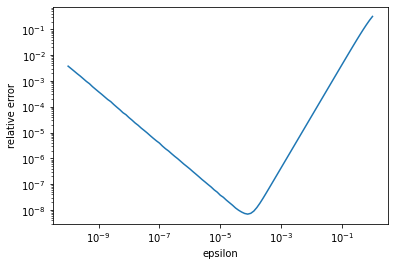

In [7]:
plt.plot(grid, values)
plt.xlabel("epsilon")
plt.ylabel("relative error")
plt.xscale('log')
plt.yscale('log')
plt.show()